In [1]:
%pwd

u'/home/chekalin/Dev/fast-ai-homework/lesson1hw'

In [2]:
LESSON_HOME = '/home/chekalin/Dev/fast-ai-homework/lesson1hw'
DATA_HOME = LESSON_HOME + '/data'
%cd $LESSON_HOME

/home/chekalin/Dev/fast-ai-homework/lesson1hw


Download dataset from kaggle using [kaggle-cli](https://github.com/floydwch/kaggle-cli) into data/ folder and unzip it
```bash
kg download -c dogs-vs-cats-redux-kernels-edition
unzip train.zip; unzip test.zip
```

Expected structure:
```
data/
├── sample_submission.csv
├── test
│   ├── 1.jpg
│   ├── 10.jpg
│   ├── 100.jpg
│   ...
├── test.zip
├── train
│   ├── cat.0.jpg
│   ├── cat.1.jpg
│   ├── cat.10.jpg
│   ├── cat.100.jpg
│   ├── cat.1000.jpg
│   ├── cat.10000.jpg
│   ├── cat.10001.jpg
│   ...  
│   ├── dog.9996.jpg
│   ├── dog.9997.jpg
│   ├── dog.9998.jpg
│   └── dog.9999.jpg
└── train.zip
```

In [3]:
%mkdir -p $DATA_HOME/sample/train
%mkdir -p $DATA_HOME/sample/valid
%mkdir -p $DATA_HOME/sample/test
%mkdir -p $DATA_HOME/sample/results
%mkdir -p $DATA_HOME/valid
%mkdir -p $DATA_HOME/results

# Create Validation Set and Sample

In [4]:
% cd $DATA_HOME/train

/home/chekalin/Dev/fast-ai-homework/lesson1hw/data/train


In [5]:
from glob import glob
import numpy as np
import os

training_files = glob('*.jpg')
validation_set_size = int(len(training_files) * .1)

shuffled_training_files = np.random.permutation(training_files)
for i in range(validation_set_size): 
    os.rename(shuffled_training_files[i], DATA_HOME + '/valid/' + shuffled_training_files[i])

In [6]:
from shutil import copyfile
from random import shuffle

training_files = glob('*.jpg')
shuffle(training_files)
sample_train_size = 240
sample_valid_size = int(sample_train_size / 3)

for i in range(sample_train_size): 
    random_file = training_files.pop()
    copyfile(random_file, DATA_HOME + '/sample/train/' + random_file)

for i in range(sample_valid_size): 
    random_file = training_files.pop()
    copyfile(random_file, DATA_HOME + '/sample/valid/' + random_file)

In [7]:
% cd $DATA_HOME/test

/home/chekalin/Dev/fast-ai-homework/lesson1hw/data/test


In [8]:
test_files = glob('*.jpg')
shuffle(test_files)

sample_test_size = int(sample_train_size / 3);

for i in range(sample_test_size): 
    random_file = test_files.pop()
    copyfile(random_file, DATA_HOME + '/sample/test/' + random_file)

# Sort each folder by label

In [9]:
def move_to_label_folders(base_folder):
    % cd $base_folder
    % mkdir -p cats
    % mv cat.*.jpg cats/
    % mkdir -p dogs
    % mv dog.*.jpg dogs/
    
def move_all_to_unknown_folder(base_folder):
    % cd $base_folder
    % mkdir -p unknown
    % mv *.jpg unknown/

In [10]:
move_to_label_folders(DATA_HOME + '/sample/train');
move_to_label_folders(DATA_HOME + '/sample/valid');
move_all_to_unknown_folder(DATA_HOME + '/sample/test');

move_to_label_folders(DATA_HOME + '/train');
move_to_label_folders(DATA_HOME + '/valid');
move_all_to_unknown_folder(DATA_HOME + '/test');

/home/chekalin/Dev/fast-ai-homework/lesson1hw/data/sample/train
/home/chekalin/Dev/fast-ai-homework/lesson1hw/data/sample/valid
/home/chekalin/Dev/fast-ai-homework/lesson1hw/data/sample/test
/home/chekalin/Dev/fast-ai-homework/lesson1hw/data/train
/home/chekalin/Dev/fast-ai-homework/lesson1hw/data/valid
/home/chekalin/Dev/fast-ai-homework/lesson1hw/data/test


Verify directory structure is correct

In [11]:
% cd $DATA_HOME

/home/chekalin/Dev/fast-ai-homework/lesson1hw/data


In [12]:
for dirpath, dirnames, filenames in os.walk(DATA_HOME):
    relative = dirpath[len(os.getcwd()):]
    if (len(filenames)): print "Files in {}: {}".format(relative, len(filenames))


Files in : 3
Files in /sample/train/dogs: 129
Files in /sample/train/cats: 111
Files in /sample/test/unknown: 80
Files in /sample/valid/dogs: 42
Files in /sample/valid/cats: 38
Files in /train/dogs: 11251
Files in /train/cats: 11249
Files in /test/unknown: 12500
Files in /valid/dogs: 1249
Files in /valid/cats: 1251


# Train model

In [13]:
% cd $LESSON_HOME

/home/chekalin/Dev/fast-ai-homework/lesson1hw


In [14]:
from keras import backend

print "using " + backend.backend()

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is enabled with initial size: 75.0% of memory, cuDNN 5110)


using theano


In [15]:
batch_size = 64
no_of_epochs = 1
path = DATA_HOME
# path = DATA_HOME + '/sample'
results_path = path + '/results'

In [16]:
import numpy as np

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils.data_utils import get_file

vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def vgg_preprocess(x):
    """
        Subtracts the mean RGB value, and transposes RGB to BGR.
        The mean RGB was computed on the image set used to train the VGG model.
        Args: 
            x: Image array (height x width x channels)
        Returns:
            Image array (height x width x transposed_channels)
    """
    x = x - vgg_mean
    return x[:, ::-1] # reverse axis rgb->bgr

def addConvBlock(model, layers, filters):
        """
            Adds a specified number of ZeroPadding and Covolution layers
            to the model, and a MaxPooling layer at the very end.

            Args:
                layers (int):   The number of zero padded convolution layers
                                to be added to the model.
                filters (int):  The number of convolution filters to be 
                                created for each layer.
        """
        for i in range(layers):
            model.add(ZeroPadding2D((1, 1)))
            model.add(Convolution2D(filters, 3, 3, activation='relu'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

vgg = Sequential();
vgg.add(Lambda(vgg_preprocess, input_shape=(3,224,224), output_shape=(3,224,224)))
addConvBlock(vgg, 2, 64)
addConvBlock(vgg, 2, 128)
addConvBlock(vgg, 3, 256)
addConvBlock(vgg, 3, 512)
addConvBlock(vgg, 3, 512)
vgg.add(Flatten())

vgg.add(Dense(4096, activation='relu'))
vgg.add(Dropout(0.5))

vgg.add(Dense(4096, activation='relu'))
vgg.add(Dropout(0.5))

vgg.add(Dense(1000, activation='softmax'))

vgg.load_weights(get_file("vgg16.h5", "http://files.fast.ai/models/vgg16.h5", cache_subdir='models'))

In [17]:
vgg.classes = ['cat', 'dog']
# removing last layer that maps to imagenet 1000 classes
vgg.pop()
# making all layers not trainable (reusing loaded weights)
for layer in vgg.layers: 
    layer.trainable=False
# layer to map to two classes
vgg.add(Dense(2, activation='softmax'))
vgg.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
vgg.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [19]:
from keras.preprocessing import image

def get_batches(path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=8, class_mode='categorical'):
        return gen.flow_from_directory(path, 
                                       target_size=(224,224),
                                       class_mode=class_mode, 
                                       shuffle=shuffle, 
                                       batch_size=batch_size)

In [20]:
batches = get_batches(path + '/train', batch_size=batch_size)
val_batches = get_batches(path + '/valid', batch_size=batch_size)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [21]:
import time

latest_weights_filename = None
fitting_start_time = time.time()
for epoch in range(no_of_epochs):
    epoch_start_time = time.time()
    vgg.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1, 
                      validation_data=val_batches, nb_val_samples=val_batches.nb_sample)
    latest_weights_filename = results_path + '/ft{}.h5'.format(epoch)
    vgg.save_weights(latest_weights_filename)
    print "processing batch {} of {} epochs took {} seconds".format(epoch + 1,
                                                                     no_of_epochs,
                                                                     int(time.time() - epoch_start_time))
print "fitting took {} seconds".format(int(time.time() - fitting_start_time))

Epoch 1/1
22500/22500 [==============================] - 264s - loss: 0.1309 - acc: 0.9654 - val_loss: 0.0596 - val_acc: 0.9828
processing batch 0 of 1 batches took 342 seconds
fitting took 342 seconds


# Predicitons

In [22]:
# we can continue from this step if we already previously trained model
vgg.load_weights(latest_weights_filename)

In [23]:
test_path = path + '/valid'
test_batches = get_batches(test_path, batch_size=batch_size, shuffle=False)

Found 2500 images belonging to 2 classes.


In [24]:
predicting_start_time = time.time()
predictions = vgg.predict_generator(test_batches, test_batches.nb_sample)
print 'Prediction took {}s'.format(int(time.time() - predicting_start_time))

Prediction took 30s


In [25]:
probabilities_of_dog = predictions[:,1]

In [26]:
from keras.preprocessing import image
from utils import plots
from random import sample
%matplotlib inline

def plot_idxs(idxs, titles=None):
    if (len(idxs) == 0): return
    if (len(idxs) > 4): idxs = sample(idxs, 4)
    images = [image.load_img(test_path + "/" + test_batches.filenames[i]) for i in idxs]
    plots(images, titles=probabilities_of_dog[idxs])    

/home/chekalin/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [27]:
import numpy as np

actual_classes = test_batches.classes
predicted_classes = np.array([int(round(probability)) for probability in probabilities_of_dog])

43 wrong predictions found


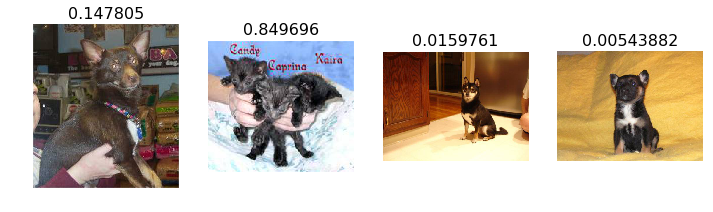

In [28]:
idxs = np.where(actual_classes != predicted_classes)[0]
print '{} wrong predictions found'.format(len(idxs))
plot_idxs(idxs)

2457 correct predictions found


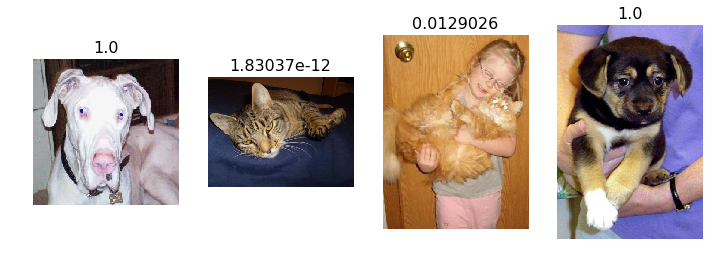

In [29]:
idxs = np.where(actual_classes == predicted_classes)[0]
print '{} correct predictions found'.format(len(idxs))
plot_idxs(idxs)

1234 correct cats found


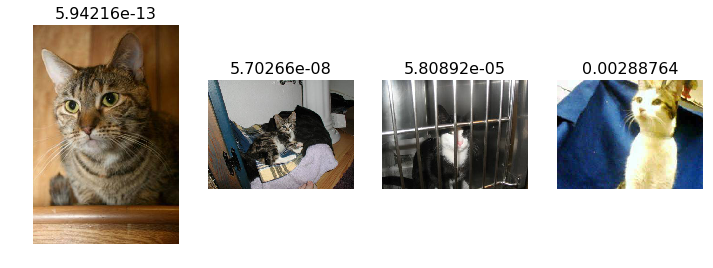

In [30]:
correct_cats = np.where((predicted_classes==0) & (predicted_classes==actual_classes))[0]
print '{} correct cats found'.format(len(correct_cats))
plot_idxs(correct_cats)

26 incorrect cats found


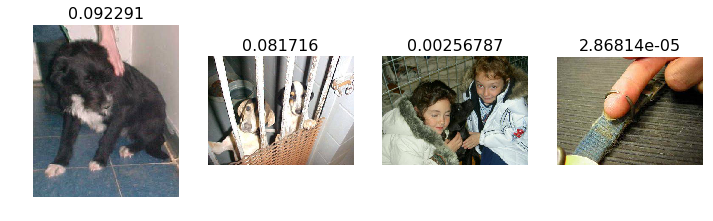

In [31]:
incorrect_cats = np.where((predicted_classes==0) & (predicted_classes!=actual_classes))[0]
print '{} incorrect cats found'.format(len(incorrect_cats))
plot_idxs(incorrect_cats)

1223 correct predictions found


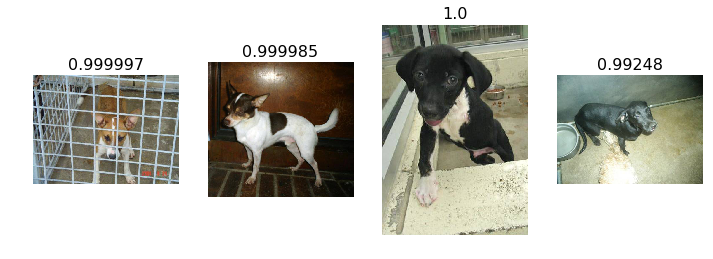

In [32]:
correct_dogs = np.where((predicted_classes==1) & (predicted_classes==actual_classes))[0]
print '{} correct predictions found'.format(len(correct_dogs))
plot_idxs(correct_dogs)

17 incorrect dogs found


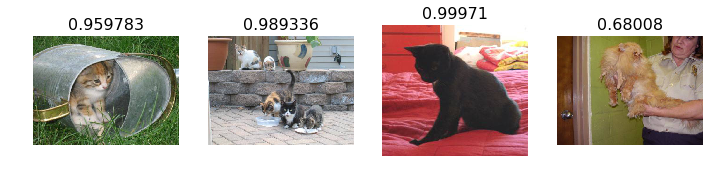

In [33]:
incorrect_dogs = np.where((predicted_classes==1) & (predicted_classes!=actual_classes))[0]
print '{} incorrect dogs found'.format(len(incorrect_dogs))
plot_idxs(incorrect_dogs)

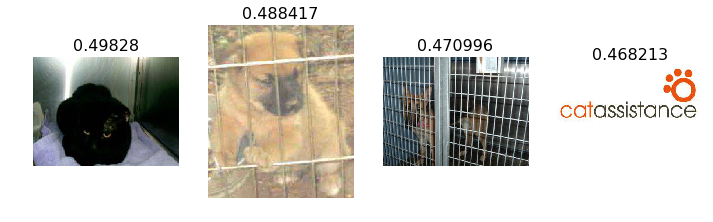

In [34]:
most_uncertain = np.argsort(np.abs(probabilities_of_dog-0.5))
plot_idxs(most_uncertain[:4])

[[1234   17]
 [  26 1223]]


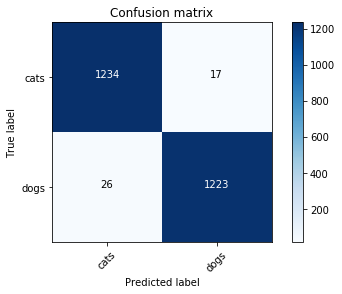

In [35]:
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix

cm = confusion_matrix(actual_classes, predicted_classes)
plot_confusion_matrix(cm, test_batches.class_indices)

In [36]:
from sklearn.metrics import precision_score, log_loss, recall_score

precision = precision_score(actual_classes, predicted_classes);
recall = recall_score(actual_classes, predicted_classes)
f1 = (2 * precision * recall) / (precision + recall)

print 'Precision score: {:.4f}%'.format(precision)
print 'Recall score: {:.4f}%'.format(recall)
print 'F1: {:.4f}%'.format(f1)

print 'Log Loss: {:.4f}%'.format(log_loss(actual_classes, probabilities_of_dog))
adjusted_probs = probabilities_of_dog.clip(min=0.05, max=0.95)
print 'Adjusted Log Loss: {:.4f}%'.format(log_loss(actual_classes, probabilities_of_dog.clip(min=0.05, max=0.95)))

Precision score: 0.9863%
Recall score: 0.9792%
F1: 0.9827%
Log Loss: nan%
Adjusted Log Loss: 0.0895%


# Run predicitons on test set and create csv for submission

In [37]:
# we can continue from this step if we already previously trained model
vgg.load_weights(latest_weights_filename)

In [38]:
test_path = path + '/test'
test_batches = get_batches(test_path, batch_size=batch_size, shuffle=False)

Found 12500 images belonging to 1 classes.


In [39]:
predicting_start_time = time.time()
predictions = vgg.predict_generator(test_batches, test_batches.nb_sample)
print 'Prediction took {}s'.format(int(time.time() - predicting_start_time))
probabilities_of_dog = predictions[:,1].clip(min=0.05, max=0.95)

Prediction took 136s


In [40]:
import csv

results_file = path + '/results/submission.csv'
file = open(results_file, "wb")
writer = csv.writer(file, delimiter=',', quoting=csv.QUOTE_NONE)
writer.writerow(["id", "label"])

sample_idx = 0
for filename in test_batches.filenames:
    sample_id = filename.replace("unknown/", "").replace(".jpg", "")
    writer.writerow([sample_id, probabilities_of_dog[sample_idx]])
    sample_idx += 1

file.close()

In [41]:
from IPython.display import FileLink
%cd $LESSON_HOME
relative_path_to_results = results_file.replace(LESSON_HOME, '')[1:]
FileLink(relative_path_to_results)

/home/chekalin/Dev/fast-ai-homework/lesson1hw


/home/chekalin/Dev/fast-ai-homework/lesson1hw/data/results/submission.csv